In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import os, sys, subprocess, json, argparse
from itertools import product
from collections import defaultdict

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device:", device)

dir_root = ''
# If using google colab
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive/')
    dir_root = '/content/drive/MyDrive/Colab Notebooks/ESE546/hw5'

print("dir_root:", dir_root)

device: cuda
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
dir_root: /content/drive/MyDrive/Colab Notebooks/ESE546/hw5


In [4]:
# Download the MNIST dataset (skip if already exists)
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)
print(train_dataset.data.shape)
print(test_dataset.data.shape)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 15.9MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 481kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.42MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 9.24MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


In [5]:
# Create dictionaries to store indices for each digit
digit_to_indices = defaultdict(list)

# Get indices for each digit in the training set
for idx, (_, label) in enumerate(train_dataset):
    digit_to_indices[label].append(idx)

# Extract 1000 images per digit and subsample to 14x14
images_per_digit = 1000
target_size = 14
extracted_images = {}
extracted_labels = {}

for digit in range(10):
    # Randomly sample 1000 indices for this digit
    selected_indices = np.random.choice(digit_to_indices[digit], images_per_digit, replace=False)

    digit_images = []
    digit_labels = []

    for idx in selected_indices:
        image, label = train_dataset[idx]
        # Subsample image to 14x14
        # Add batch dimension for F.interpolate
        image = image.unsqueeze(0)
        image = F.interpolate(image, size=(target_size, target_size), mode='bilinear', align_corners=False)
        image = image.squeeze(0)

        digit_images.append(image)
        digit_labels.append(label)

    # Stack the images and labels
    extracted_images[digit] = torch.stack(digit_images)
    extracted_labels[digit] = torch.tensor(digit_labels)

# Combine all digits into single tensors
all_images = torch.cat([extracted_images[d] for d in range(10)])  # Shape: [10000, 1, 14, 14]
all_images = (all_images > 0.5).float()  # Binarize the images
all_labels = torch.cat([extracted_labels[d] for d in range(10)])  # Shape: [10000]

torch.Size([10000, 1, 14, 14])
torch.Size([10000])
Digit 0 has 1000 images
Digit 1 has 1000 images
Digit 2 has 1000 images
Digit 3 has 1000 images
Digit 4 has 1000 images
Digit 5 has 1000 images
Digit 6 has 1000 images
Digit 7 has 1000 images
Digit 8 has 1000 images
Digit 9 has 1000 images


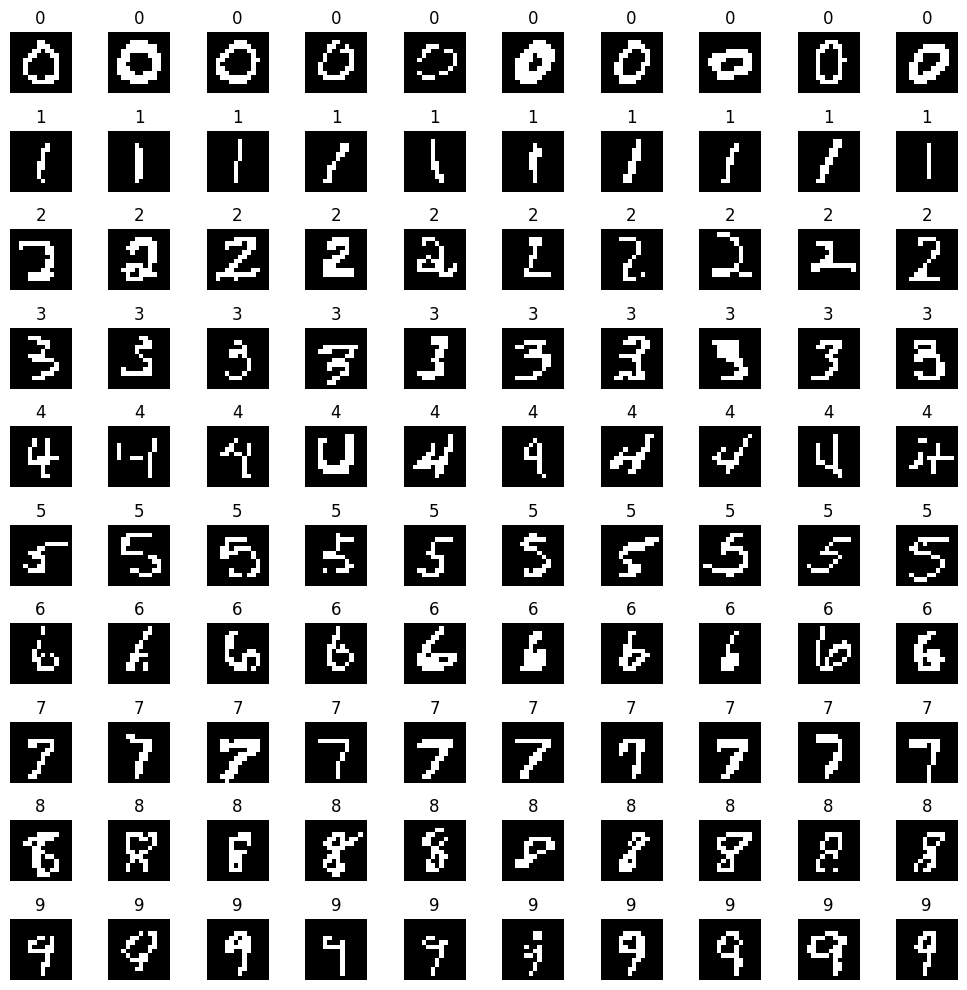

In [6]:
# Validate the dataset

print(all_images.shape)  # Shape: [10000, 1, 14, 14]
print(all_labels.shape)  # Shape: [10000]

# Check if each digit has 1000 images
for digit in range(10):
    num_images = (all_labels == digit).sum().item()
    print(f"Digit {digit} has {num_images} images")

# Randomly visualize 10 images per label to check if labels and images correspond
def visualize_random_images_per_label(images, labels, num_images=10):
    fig, axs = plt.subplots(10, num_images, figsize=(num_images, 10))

    for digit in range(10):
        digit_indices = (labels == digit).nonzero(as_tuple=True)[0]
        # Randomly select num_images indices
        selected_indices = np.random.choice(digit_indices, num_images, replace=False)

        for i, idx in enumerate(selected_indices):
            axs[digit, i].imshow(images[idx].squeeze(0), cmap='gray')
            axs[digit, i].axis('off')
            axs[digit, i].set_title(labels[idx].item())

    plt.tight_layout()
    plt.show()

# Visualize the images and labels
visualize_random_images_per_label(all_images, all_labels)

In [7]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder (14x14=196 inputs -> 128 -> 16 for mean and std dev)
        self.encoder_fc1 = nn.Linear(14 * 14, 128)
        self.encoder_fc2 = nn.Linear(128, 16)  # 8 for mean, 8 for std dev

        # Decoder (8 -> 128 -> 196 outputs)
        self.decoder_fc1 = nn.Linear(8, 128)
        self.decoder_fc2 = nn.Linear(128, 14 * 14)

    def encode(self, x):
        # Flatten the input
        x = x.view(-1, 14 * 14)

        h1 = torch.tanh(self.encoder_fc1(x))
        h2 = self.encoder_fc2(h1)

        # Split into mean and log_var
        mean = h2[:, :8]
        log_var = h2[:, 8:]
        return mean, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = torch.tanh(self.decoder_fc1(z))
        h4 = torch.sigmoid(self.decoder_fc2(h3))

        return h4.view(-1, 1, 14, 14)

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

def loss_function(model, x, mu, log_var):
    # Sample z twice and average the reconstruction loss
    z1 = model.reparameterize(mu, log_var)
    recon_x1 = model.decode(z1)
    z2 = model.reparameterize(mu, log_var)
    recon_x2 = model.decode(z2)

    # Compute log p_v(x|z) for both samples using Bernoulli log probability
    log_p1 = torch.sum(
        x.view(-1, 14*14) * torch.log(recon_x1.view(-1, 14*14) + 1e-8) +
        (1-x.view(-1, 14*14)) * torch.log(1-recon_x1.view(-1, 14*14) + 1e-8),
        dim=1
    )
    log_p2 = torch.sum(
        x.view(-1, 14*14) * torch.log(recon_x2.view(-1, 14*14) + 1e-8) +
        (1-x.view(-1, 14*14)) * torch.log(1-recon_x2.view(-1, 14*14) + 1e-8),
        dim=1
    )
    expected_log_p = 0.5 * (log_p1 + log_p2).mean()

    # KL divergence
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=1).mean()

    return -(expected_log_p - KLD), -expected_log_p, KLD

# Training function
def train_vae(model, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    total_expected_log_p = 0
    total_kld = 0
    num_batches = 0

    for batch_idx, data in enumerate(train_loader):
        data = data[0].to(device)
        optimizer.zero_grad()

        recon_batch, mu, log_var = model(data)
        loss, expected_log_p, kld = loss_function(model, data, mu, log_var)

        loss.backward()
        train_loss += loss.item()
        total_expected_log_p += expected_log_p.item()
        total_kld += kld.item()
        num_batches += 1

        optimizer.step()

    return (train_loss / num_batches,
            total_expected_log_p / num_batches,
            total_kld / num_batches)

In [11]:
# Setup training
batch_size = 128
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(all_images),
    batch_size=batch_size, shuffle=True)

model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

expected_log_p_history = []
kld_history = []

# Training loop
n_epochs = 1000
for epoch in range(1, n_epochs + 1):
    train_loss, expected_log_p, kld = train_vae(model, train_loader, optimizer, epoch)
    expected_log_p_history.append(expected_log_p)
    kld_history.append(kld)
    if epoch % 10 == 0:
        print(f'Epoch {epoch}: Average loss = {train_loss:.4f}')

Epoch 10: Average loss = 40.7415
Epoch 20: Average loss = 37.8377
Epoch 30: Average loss = 36.5413
Epoch 40: Average loss = 35.6914
Epoch 50: Average loss = 35.0743
Epoch 60: Average loss = 34.6355
Epoch 70: Average loss = 34.2943
Epoch 80: Average loss = 33.9499
Epoch 90: Average loss = 33.7116
Epoch 100: Average loss = 33.5074
Epoch 110: Average loss = 33.3069
Epoch 120: Average loss = 33.1960
Epoch 130: Average loss = 33.0695
Epoch 140: Average loss = 32.9212
Epoch 150: Average loss = 32.7980
Epoch 160: Average loss = 32.6980
Epoch 170: Average loss = 32.5975
Epoch 180: Average loss = 32.5360
Epoch 190: Average loss = 32.4647
Epoch 200: Average loss = 32.4009
Epoch 210: Average loss = 32.3134
Epoch 220: Average loss = 32.2302
Epoch 230: Average loss = 32.2259
Epoch 240: Average loss = 32.0474
Epoch 250: Average loss = 32.0624
Epoch 260: Average loss = 32.0193
Epoch 270: Average loss = 32.0266
Epoch 280: Average loss = 31.9543
Epoch 290: Average loss = 31.8952
Epoch 300: Average loss

(iii) Plot the first and second term of ELBO in Eq. (1) separately as a function of the number of weight updates.

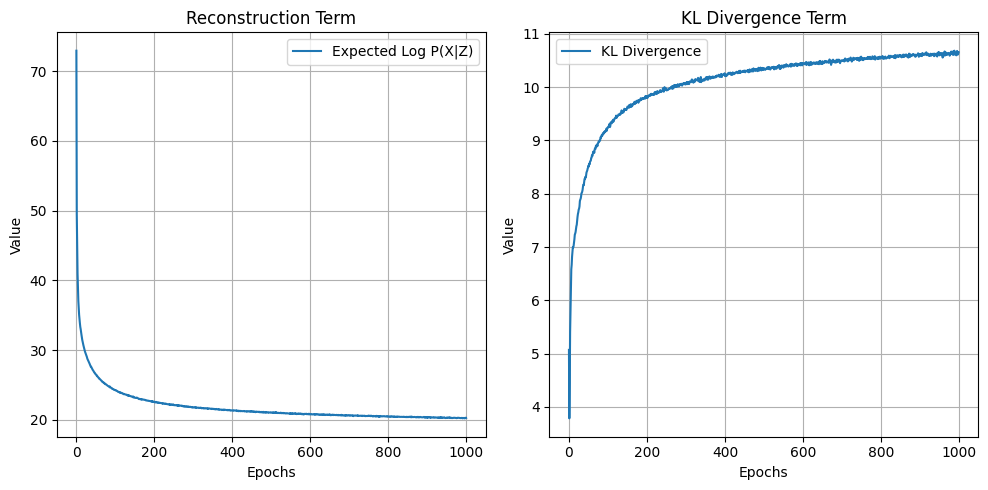

In [12]:
# Plot the first and second term of ELBO in Eq. (1) separately as a function of the number of weight updates.

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(expected_log_p_history, label='Expected Log P(X|Z)')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Reconstruction Term')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(kld_history, label='KL Divergence')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('KL Divergence Term')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

(iv) Pick 8 MNIST images, run them through the encoder and the decoder to plot the output of the decoder side-by-side with the original images.

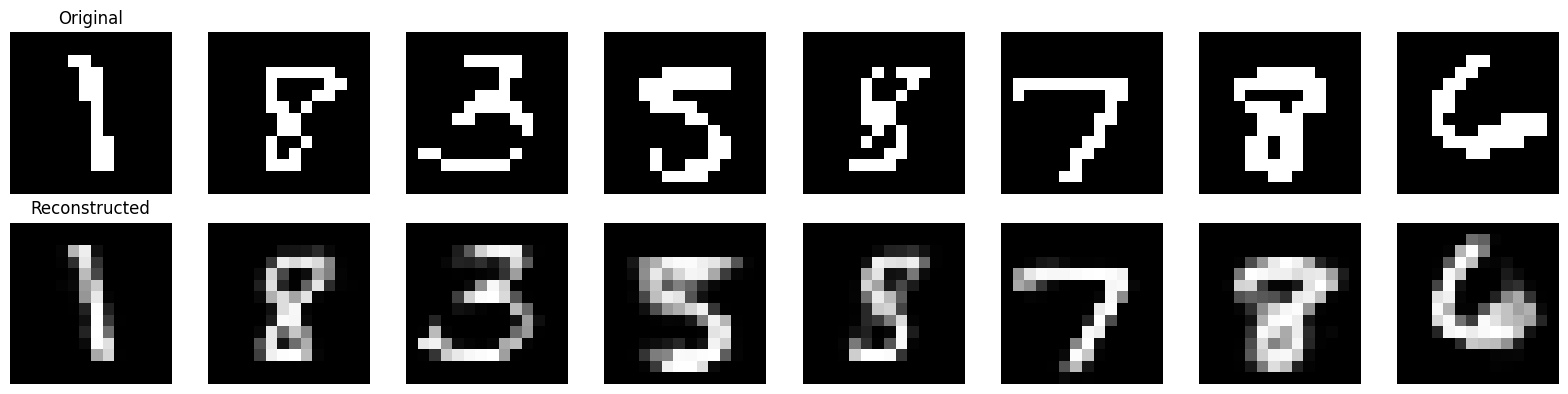

In [13]:
# Pick 8 MNIST images, run them through the encoder and the decoder to plot the original and reconstructed images side by side

selected_indices = np.random.choice(len(all_images), 8, replace=False)
selected_images = all_images[selected_indices]

with torch.no_grad():
    recon_images, _, _ = model(selected_images.to(device))

fig, axs = plt.subplots(2, 8, figsize=(16, 4))

for i in range(8):
    axs[0, i].imshow(selected_images[i].squeeze(0), cmap='gray')
    axs[0, i].axis('off')
    if i == 0:
        axs[0, i].set_title('Original', fontsize=12)

    axs[1, i].imshow(recon_images[i].squeeze(0).cpu(), cmap='gray')
    axs[1, i].axis('off')
    if i == 0:
        axs[1, i].set_title('Reconstructed', fontsize=12)

plt.tight_layout()
plt.show()

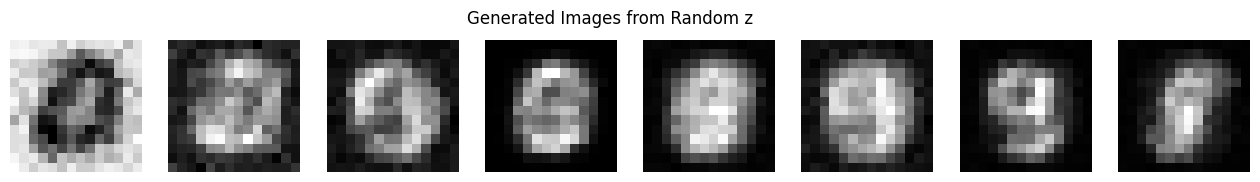

In [18]:
# (v) Sample from the generative model directly
def generate_samples(model, num_samples=8):
    with torch.no_grad():
        # Sample z from standard Gaussian
        z = torch.randn(num_samples, 8).to(device)
        # Generate images through decoder
        generated_images = model.decode(z)

    # Plot the generated images
    fig, axs = plt.subplots(1, num_samples, figsize=(2*num_samples, 2))
    for i in range(num_samples):
        axs[i].imshow(generated_images[i].cpu().squeeze(0), cmap='gray')
        axs[i].axis('off')
    plt.suptitle('Generated Images from Random z')
    plt.show()

# Generate samples
generate_samples(model)

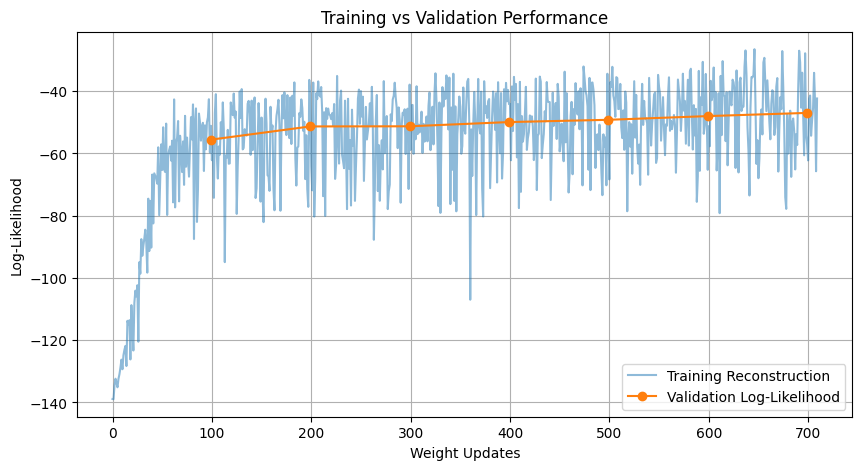

In [20]:
# (vi) Compute validation performance

# First, let's create a validation set (10% of the data)
val_size = int(0.1 * len(all_images))
train_data, val_data = torch.utils.data.random_split(
    all_images, [len(all_images) - val_size, val_size]
)

val_loader = torch.utils.data.DataLoader(
    val_data, batch_size=100, shuffle=False
)

def compute_validation_likelihood(model, val_loader, num_samples=10):
    model.eval()
    total_log_likelihood = 0
    num_batches = 0

    with torch.no_grad():
        for data in val_loader:
            data = data[0].to(device)
            batch_size = data.size(0)

            # Get encoder parameters
            mu, log_var = model.encode(data)

            # Compute log likelihood using multiple samples
            batch_log_likelihood = 0
            for _ in range(num_samples):
                z = model.reparameterize(mu, log_var)
                recon = model.decode(z)

                # Compute log p(x|z) using Bernoulli distribution
                log_p = torch.sum(
                    data.view(-1, 196) * torch.log(recon.view(-1, 196) + 1e-8) +
                    (1 - data.view(-1, 196)) * torch.log(1 - recon.view(-1, 196) + 1e-8),
                    dim=1
                ).mean()

                batch_log_likelihood += log_p.item()

            total_log_likelihood += batch_log_likelihood / num_samples
            num_batches += 1

    return total_log_likelihood / num_batches

# Retrain the model while tracking validation performance
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, shuffle=True
)

train_recon_history = []
val_likelihood_history = []
updates_per_val = 100
total_updates = 0

for epoch in range(10):  # Reduced epochs for demonstration
    model.train()
    for batch_idx, data in enumerate(train_loader):
        data = data[0].to(device)
        optimizer.zero_grad()

        recon_batch, mu, log_var = model(data)
        loss, expected_log_p, kld = loss_function(model, data, mu, log_var)

        loss.backward()
        optimizer.step()

        train_recon_history.append(-expected_log_p.item())  # Negative because we want log-likelihood
        total_updates += 1

        if total_updates % updates_per_val == 0:
            val_ll = compute_validation_likelihood(model, val_loader)
            val_likelihood_history.append(val_ll)

# Plot training reconstruction likelihood vs validation likelihood
plt.figure(figsize=(10, 5))
plt.plot(range(len(train_recon_history)), train_recon_history,
         label='Training Reconstruction', alpha=0.5)

# Create x-axis points for validation plot
val_x = np.arange(updates_per_val-1, len(train_recon_history), updates_per_val)[:len(val_likelihood_history)]
plt.plot(val_x, val_likelihood_history,
         label='Validation Log-Likelihood',
         marker='o')

plt.xlabel('Weight Updates')
plt.ylabel('Log-Likelihood')
plt.legend()
plt.title('Training vs Validation Performance')
plt.grid(True)
plt.show()

In [ ]:
# Shut down if it's google colab
# First sleep for a while so that changes to the notebook are saved
import time
time.sleep(30)

if 'google.colab' in str(get_ipython()):
    from google.colab import runtime
    runtime.unassign()